* source : kaggle
* Data : [https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)

# 라이브러리 로드

In [1]:
# !pip install pingouin

In [460]:
# 데이터 분석
import pandas as pd
import numpy as np

# 통계
import pingouin as pg
from scipy.stats import chisquare
import math

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# 컬럼 출력 생략 해제
pd.set_option('display.max_columns', None)

# 시각화 한글 표시
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 상관관계 파악
from scipy.stats import chi2_contingency
from sklearn.datasets import make_blobs
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# 머신러닝
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import AdaBoostClassifier

# 머신러닝

## 데이터 로드

In [422]:
df_raw = pd.read_csv(url, index_col='EmployeeNumber')

# EDA 해서 빼기로 했던 변수들
drop_cols = ['Department', 'DistanceFromHome', 'Gender', 'NumCompaniesWorked', 'PercentSalaryHike', 
             'PerformanceRating', 'RelationshipSatisfaction', 'TrainingTimesLastYear' , 'YearsSinceLastPromotion',
             'DailyRate', 'HourlyRate', 'MonthlyRate', 'Over18', 'EmployeeCount', 'StandardHours']

df_drop = df_raw.drop(columns=drop_cols)

# 변경에 파생변수 추가 및 라벨인코딩
label_encoder = LabelEncoder()

# 연차 파생변수 생성 : 5년마다 TotalWorkingYears 나누기
df_drop['TotalWorkingYears_Group'] = pd.cut(df_drop['TotalWorkingYears'], bins=range(0, df_drop['TotalWorkingYears'].max()+6, 5), right=False)
df_drop['TotalWorkingYears_Group_label'] = label_encoder.fit_transform(df_drop['TotalWorkingYears_Group'])
df_drop = df_drop.drop(columns=['TotalWorkingYears_Group','TotalWorkingYears'])

# 나이대 파생변수 생성
df_drop["Age_cat"] = (df_raw["Age"] // 10) * 10
df_drop['Age_cat_label'] = label_encoder.fit_transform(df_drop['Age_cat'])
df_drop = df_drop.drop(columns=['Age_cat', 'Age'])

## 데이터 클리닝
- 이상치 처리 계획

In [423]:
num_cols = df_drop.select_dtypes('number').columns.tolist()

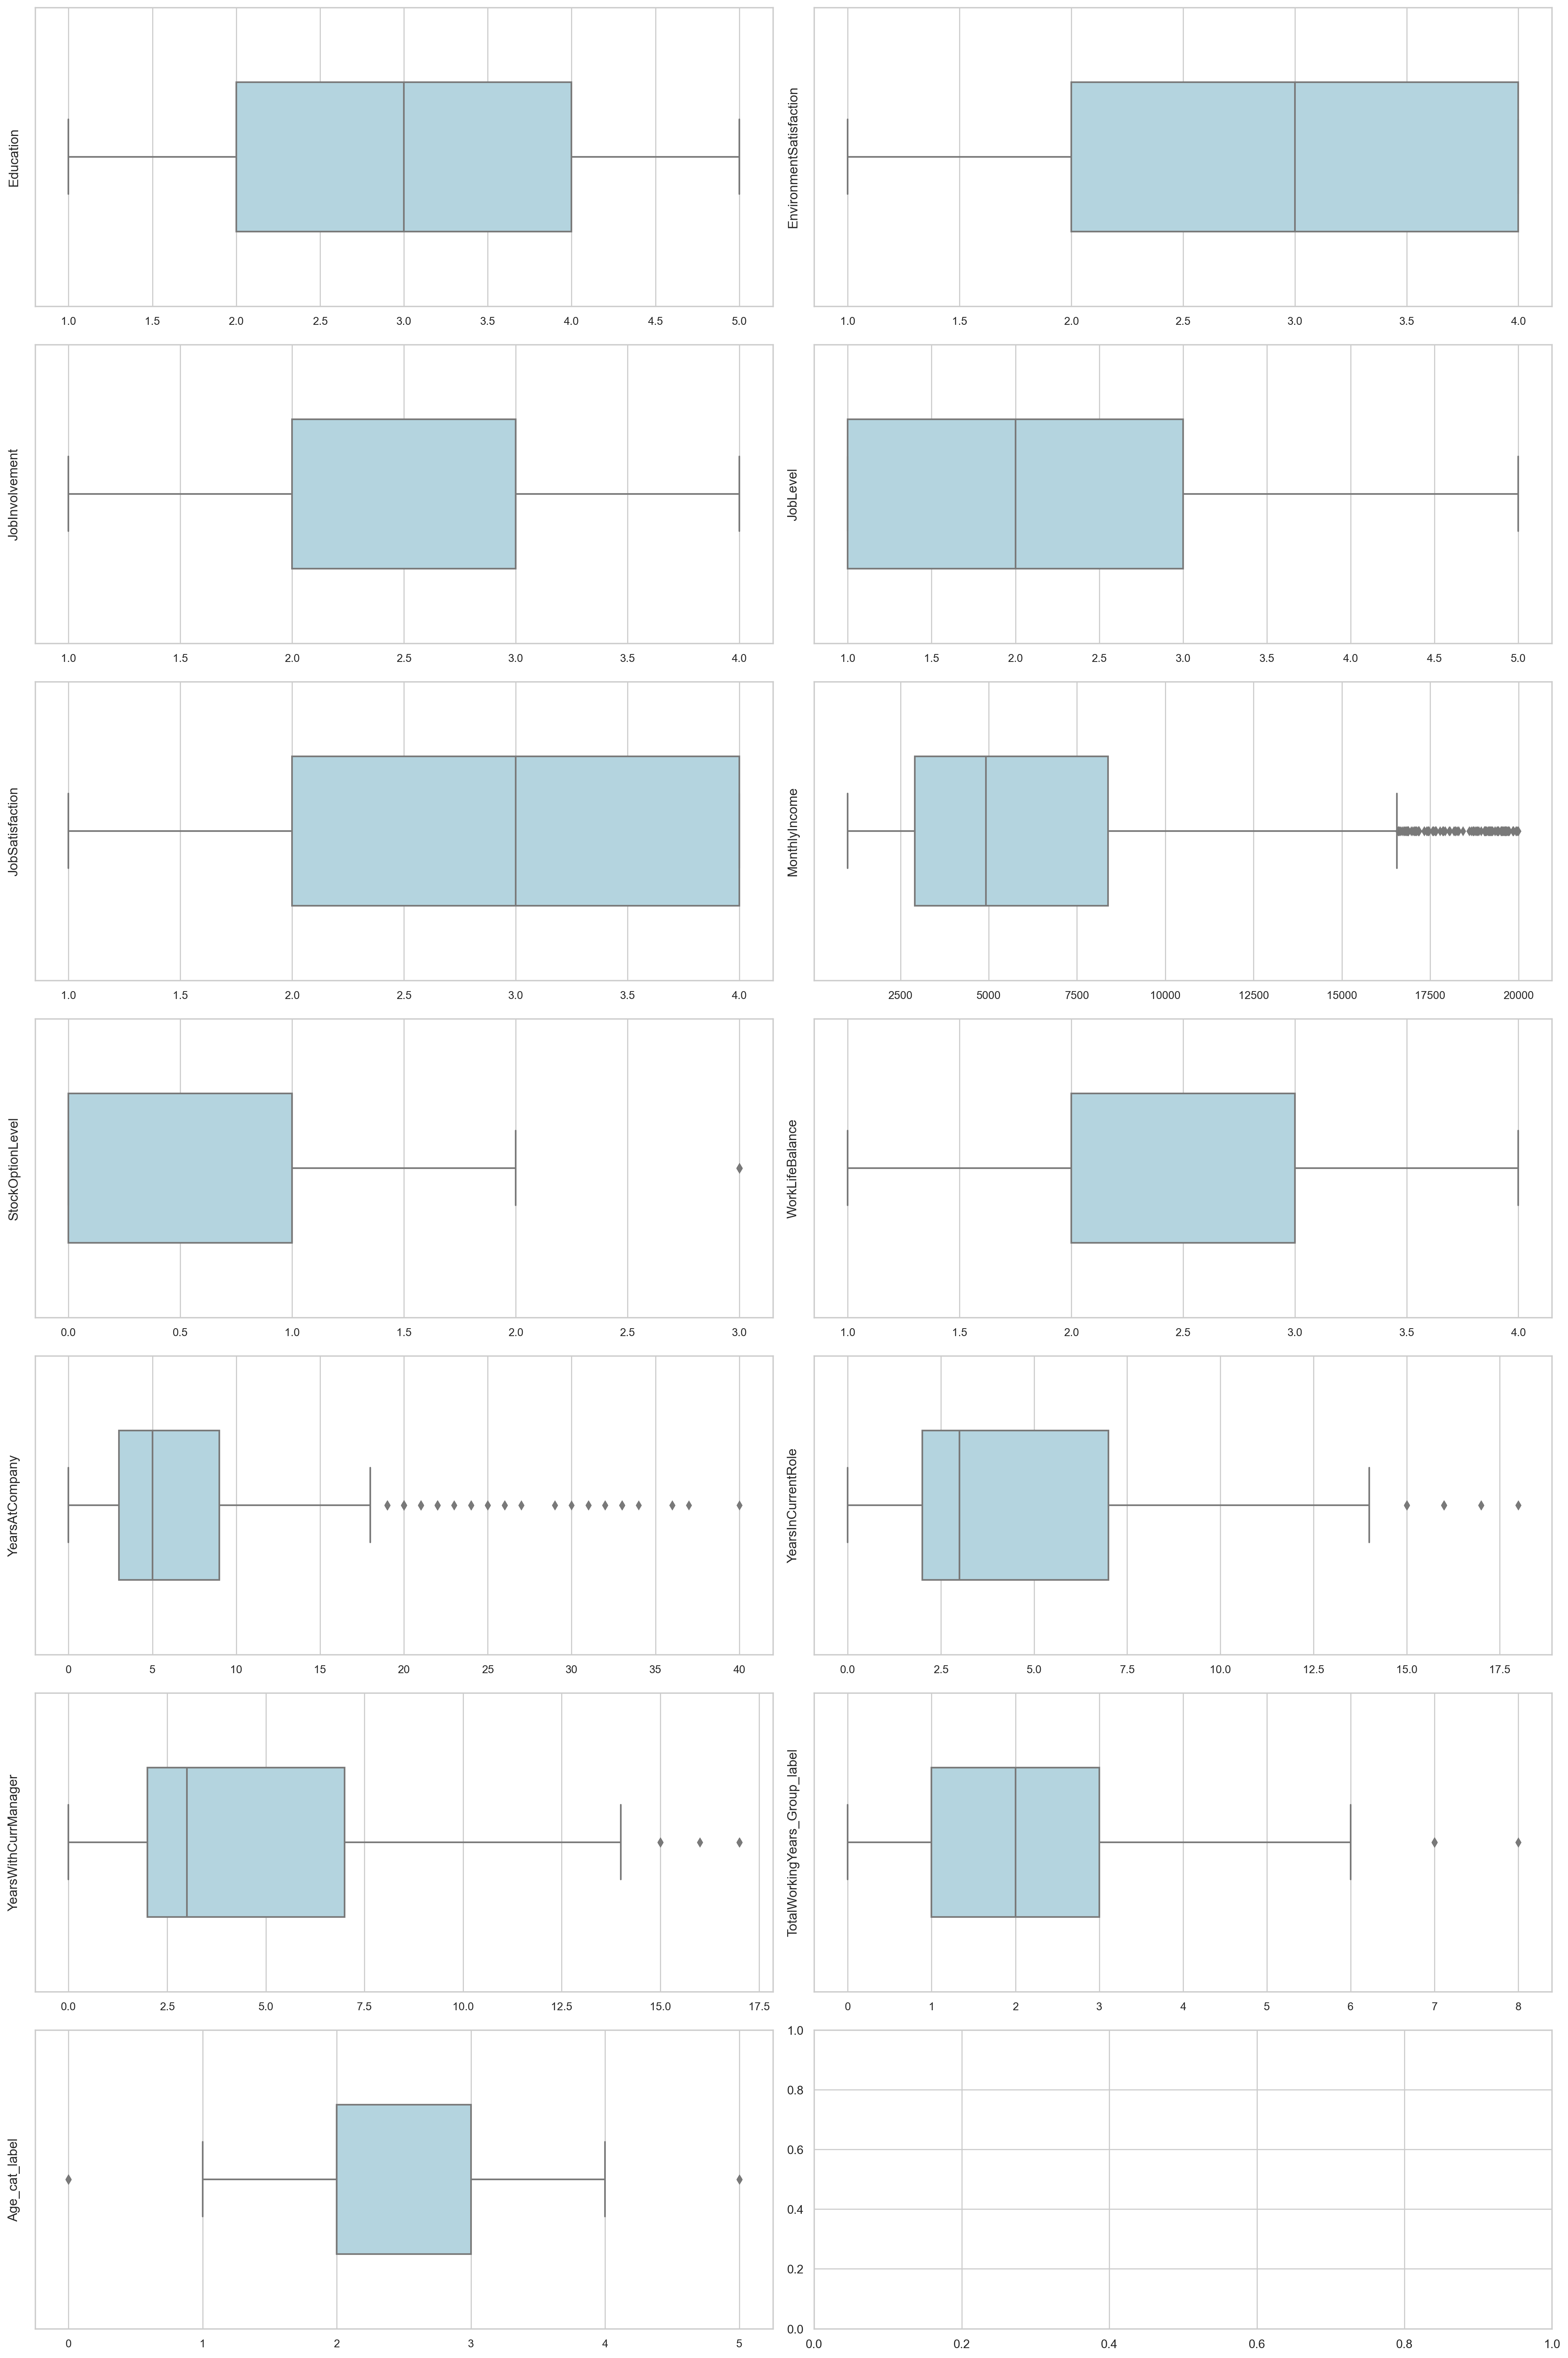

In [424]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=math.ceil(len(num_cols)/2), ncols=2, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df_drop[col], ax=axes[i], color='lightblue', width=0.5)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col, fontsize=12)
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='JobLevel', ylabel='count'>

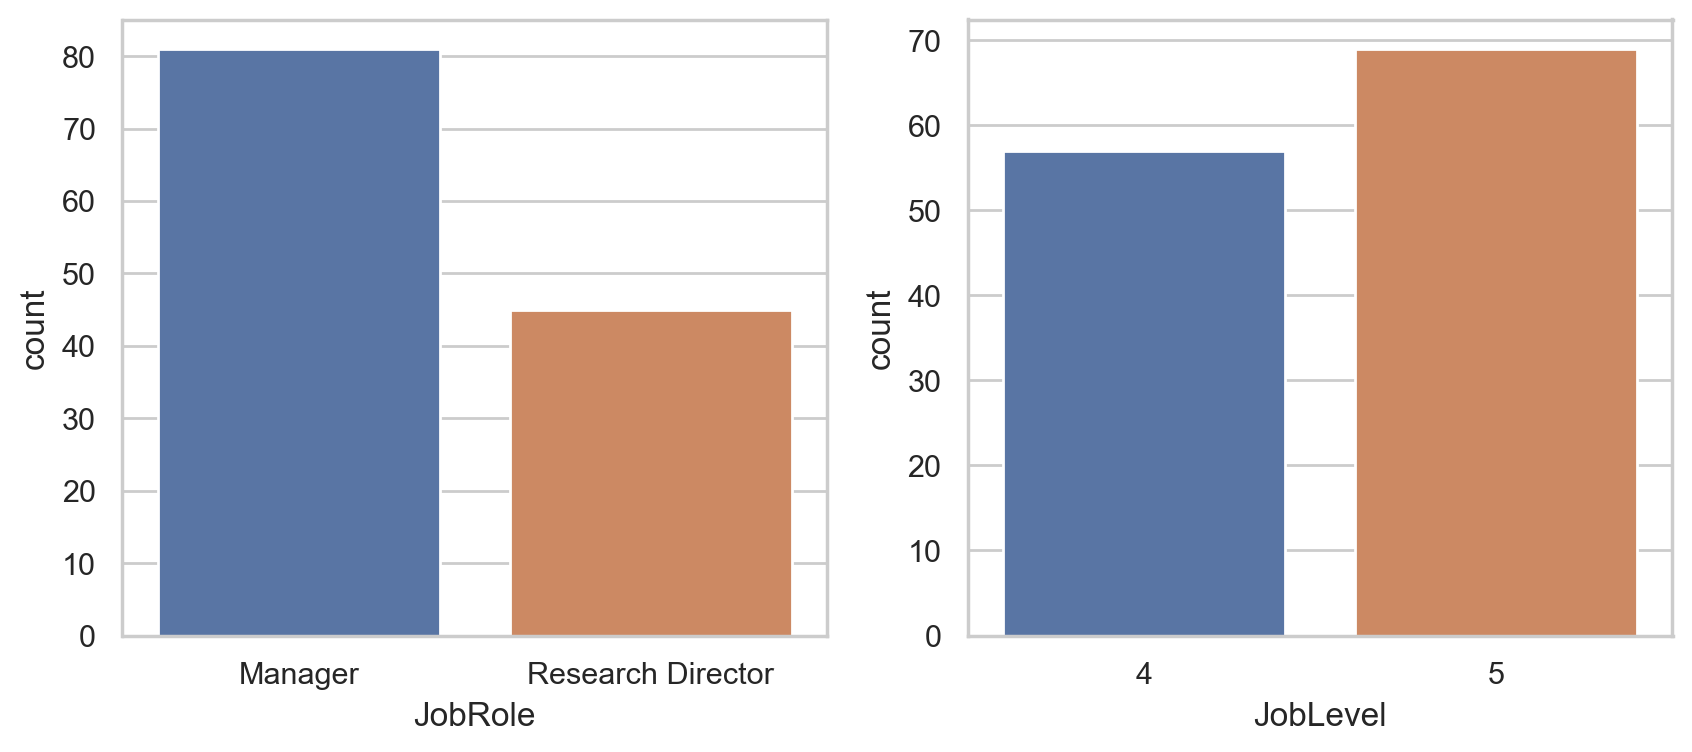

In [425]:
# MonthlyIncome 이상치 처리 확인 > 내비두기
df_drop[df_drop["MonthlyIncome"] >= 16000]["JobLevel"] 

fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.countplot(data=df_drop[df_drop["MonthlyIncome"] >= 16000], x='JobRole', ax=ax[0])
sns.countplot(data=df_drop[df_drop["MonthlyIncome"] >= 16000], x='JobLevel', ax=ax[1])

* HR 데이터(개인 정보 데이터)인 점을 고려하여, 특이하게 이상한 데이터 없음 
* 이상치 처리 안해도 되는 것으로 결정 !

## 성능평가 함수

In [426]:
def metrics(y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    roc_score = roc_auc_score(y_test,y_pred,average='macro')
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy,precision,recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1,roc_score,recall))
    print(classification_report(y_test, y_pred))

## 오버샘플링 성능 평가

In [436]:
df = pd.read_csv(url)
# df = pd.get_dummies(df)
df["Attrition"]

0       Yes
1        No
2       Yes
3        No
4        No
       ... 
1465     No
1466     No
1467     No
1468     No
1469     No
Name: Attrition, Length: 1470, dtype: object

In [437]:
df = pd.read_csv(url)

# 타겟 변수와 설명 변수 나누기
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# 인코딩
X = pd.get_dummies(X)
y = y.apply(lambda x: 1 if x == 'Yes' else 0)

# train, test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# BorderlineSMOTE
bsmote = BorderlineSMOTE(random_state=42)
X_resampled_b, y_resampled_b = bsmote.fit_resample(X_train, y_train)

# ADASYN
adasyn = ADASYN(random_state=42)
X_resampled_a, y_resampled_a = adasyn.fit_resample(X_train, y_train)

In [438]:
# 로지스틱 회귀 모델 생성
lr = LogisticRegression(random_state=42)

# SMOTE
# SMOTE로 샘플링한 데이터로 모델 학습 및 예측
lr.fit(X_resampled, y_resampled)
y_pred = lr.predict(X_test)

# 성능 평가
print('SMOTE 적용 결과')
print(f'{metrics(y_test, y_pred)}\n')

# BorderlineSMOTE
# BorderlineSMOTE으로 샘플링한 데이터로 모델 학습 및 예측
lr.fit(X_resampled_b, y_resampled_b)
y_pred = lr.predict(X_test)

# 성능 평가
print('BorderlineSMOTE 적용 결과')
print(f'{metrics(y_test, y_pred)}\n')

# ADASYN
# ADASYN 샘플링한 데이터로 모델 학습 및 예측
lr.fit(X_resampled_a, y_resampled_a)
y_pred = lr.predict(X_test)

# 성능 평가
print('ADASYN 적용 결과')
print(f'{metrics(y_test, y_pred)}\n')

SMOTE 적용 결과
정확도 : 0.69, 정밀도 : 0.23, 재현율 : 0.56
f1-score : 0.32, auc : 0.63
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       255
           1       0.23      0.56      0.32        39

    accuracy                           0.69       294
   macro avg       0.57      0.63      0.56       294
weighted avg       0.82      0.69      0.73       294

None

BorderlineSMOTE 적용 결과
정확도 : 0.70, 정밀도 : 0.25, 재현율 : 0.62
f1-score : 0.35, auc : 0.66
              precision    recall  f1-score   support

           0       0.92      0.71      0.81       255
           1       0.25      0.62      0.35        39

    accuracy                           0.70       294
   macro avg       0.59      0.66      0.58       294
weighted avg       0.83      0.70      0.75       294

None

ADASYN 적용 결과
정확도 : 0.70, 정밀도 : 0.25, 재현율 : 0.62
f1-score : 0.36, auc : 0.67
              precision    recall  f1-score   support

           0       0.92      0.72      0.81

/Users/jomac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/jomac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/jomac/opt/a

## 피처 최종 선정
- 기본, 변경 피처 + 로지스틱 기본으로 성능 평가 

In [439]:
df_select_feature = pd.read_csv(url, index_col='EmployeeNumber')
len(df_select_feature.columns.tolist())

34

In [440]:
# 기본
# 타겟 변수와 설명 변수 나누기
X = df_select_feature.drop('Attrition', axis=1)
y = df_select_feature['Attrition']

# X값 원핫인코딩
X = pd.get_dummies(X)

# train, test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ADASYN 오버샘플링
adasyn = ADASYN(random_state=42)
X_train_resampled_a, y_train_resampled_a = adasyn.fit_resample(X_train, y_train)
lr_adasyn = LogisticRegression(random_state=42).fit(X_train_resampled_a, y_train_resampled_a)

# 로지스틱 회귀 모델 생성
lr = LogisticRegression(random_state=42)

# ADASYN로 샘플링한 데이터로 모델 학습 및 예측
lr.fit(X_train_resampled_a, y_train_resampled_a)
y_pred_a = lr.predict(X_test)

# 성능 평가
print('기본 피처 적용 결과')
print(classification_report(y_test, y_pred_a))

기본 피처 적용 결과
              precision    recall  f1-score   support

          No       0.91      0.70      0.79       255
         Yes       0.21      0.54      0.31        39

    accuracy                           0.68       294
   macro avg       0.56      0.62      0.55       294
weighted avg       0.82      0.68      0.73       294



/Users/jomac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/jomac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [441]:
df = pd.read_csv(url, index_col='EmployeeNumber')
df_select_feature_drop = df.drop(columns=drop_cols)
len(df_select_feature_drop.columns.tolist())

19

In [442]:
# 변경에 파생변수 추가 및 라벨인코딩
label_encoder = LabelEncoder()

# 연차 파생변수 생성 : 5년마다 TotalWorkingYears 나누기
df_select_feature_drop['TotalWorkingYears_Group'] = pd.cut(df_select_feature_drop['TotalWorkingYears'], bins=range(0, df_select_feature_drop['TotalWorkingYears'].max()+6, 5), right=False)
df_select_feature_drop['TotalWorkingYears_Group_label'] = label_encoder.fit_transform(df_select_feature_drop['TotalWorkingYears_Group'])
df_select_feature_drop = df_select_feature_drop.drop(columns=['TotalWorkingYears_Group','TotalWorkingYears'])

# # 나이대 파생변수 생성
df_select_feature_drop["Age_cat"] = (df_raw["Age"] // 10) * 10
df_select_feature_drop['Age_cat_label'] = label_encoder.fit_transform(df_select_feature_drop['Age_cat'])
df_select_feature_drop = df_select_feature_drop.drop(columns=['Age_cat', 'Age'])


In [443]:
# 변경
# 타겟 변수와 설명 변수 나누기
X = df_select_feature_drop.drop('Attrition', axis=1)
y_pred = df_select_feature_drop['Attrition']

# X값 원핫인코딩
X = pd.get_dummies(X)

# train, test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42)

# ADASYN 오버샘플링
adasyn = ADASYN(random_state=42)
X_train_resampled_a, y_train_resampled_a = adasyn.fit_resample(X_train, y_train)
lr_adasyn = LogisticRegression(random_state=42).fit(X_train_resampled_a, y_train_resampled_a)

# 로지스틱 회귀 모델 생성
lr = LogisticRegression(random_state=42)

# ADASYN로 샘플링한 데이터로 모델 학습 및 예측
lr.fit(X_train_resampled_a, y_train_resampled_a)
y_pred_a = lr.predict(X_test)

# 성능 평가
print('변경 피처 적용 결과')
print(classification_report(y_test, y_pred_a))

변경 피처 적용 결과
              precision    recall  f1-score   support

          No       0.90      0.78      0.84       255
         Yes       0.24      0.46      0.32        39

    accuracy                           0.74       294
   macro avg       0.57      0.62      0.58       294
weighted avg       0.82      0.74      0.77       294



/Users/jomac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/jomac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## 머신러닝용 데이터 전처리

In [444]:
# 모델용 데이터 프레임 생성
df = df_drop.copy()

# 추가 변수 설정
df = df[["Attrition", "JobRole", "StockOptionLevel", "BusinessTravel", "OverTime", "MaritalStatus", 
       "EducationField", "JobLevel", "TotalWorkingYears_Group_label", "Age_cat_label", "EnvironmentSatisfaction",
       "JobSatisfaction"]]

# 인덱스를 EmployeeNumber로 해서 원핫인코딩하면 비어있는 인덱스가 추가되어서 행이 더 늘어난다...
df = df.reset_index(drop=True)

In [445]:
# 정답값 나누기
X = df.drop('Attrition', axis=1)
y = df_drop['Attrition']

# y값 인코딩
y = y.apply(lambda x: 1 if x == 'Yes' else 0)

X.shape

(1470, 11)

In [446]:
# 스케일링
# StandardScaler 객체 생성
scaler = StandardScaler()

# 스케일링 대상 feature 선택
num_cols = X.select_dtypes(exclude="O").columns.tolist()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [447]:
# 원핫인코딩
col_ohe = X.select_dtypes('O').columns

# OneHotEncoder 객체 생성 및 학습
ohe = OneHotEncoder(handle_unknown='ignore')

# 인코딩 범주찾기
X_ohe = ohe.fit_transform(X[col_ohe])
X_ohe.toarray()

# 인코딩된 데이터프레임 생성
df_ohe = pd.DataFrame(X_ohe.toarray(), columns=ohe.get_feature_names_out())

# 수치형과 병합
X_num = X.select_dtypes(exclude="object")
X_enc = pd.concat([X_num, df_ohe], axis=1)

#확인
print(X_enc.shape)
X_enc.head()

(1470, 29)


,StockOptionLevel,JobLevel,TotalWorkingYears_Group_label,Age_cat_label,EnvironmentSatisfaction,JobSatisfaction,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,OverTime_No,OverTime_Yes,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree
0,-0.932014,-0.057788,-0.58144,0.788240,-0.660531,1.153254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.241988,-0.057788,0.05784,0.788240,0.254625,-0.660853,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.932014,-0.961486,-0.58144,-0.252832,1.169781,0.246200,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.932014,-0.961486,-0.58144,-0.252832,1.169781,0.246200,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.241988,-0.961486,-0.58144,-1.293904,-1.575686,-0.660853,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [448]:
# train, test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, stratify=y, random_state=42)

In [449]:
# 오버샘플링
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

## 모델 학습 및 평가

### 로지스틱 기본

In [450]:
# 로지스틱 회귀 모델 학습
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train_resampled, y_train_resampled)

# 모델 성능 평가
y_pred = model_lr.predict(X_test)
metrics(y_test, y_pred)

정확도 : 0.73, 정밀도 : 0.33, 재현율 : 0.66
f1-score : 0.44, auc : 0.70
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       247
           1       0.33      0.66      0.44        47

    accuracy                           0.73       294
   macro avg       0.62      0.70      0.63       294
weighted avg       0.82      0.73      0.76       294



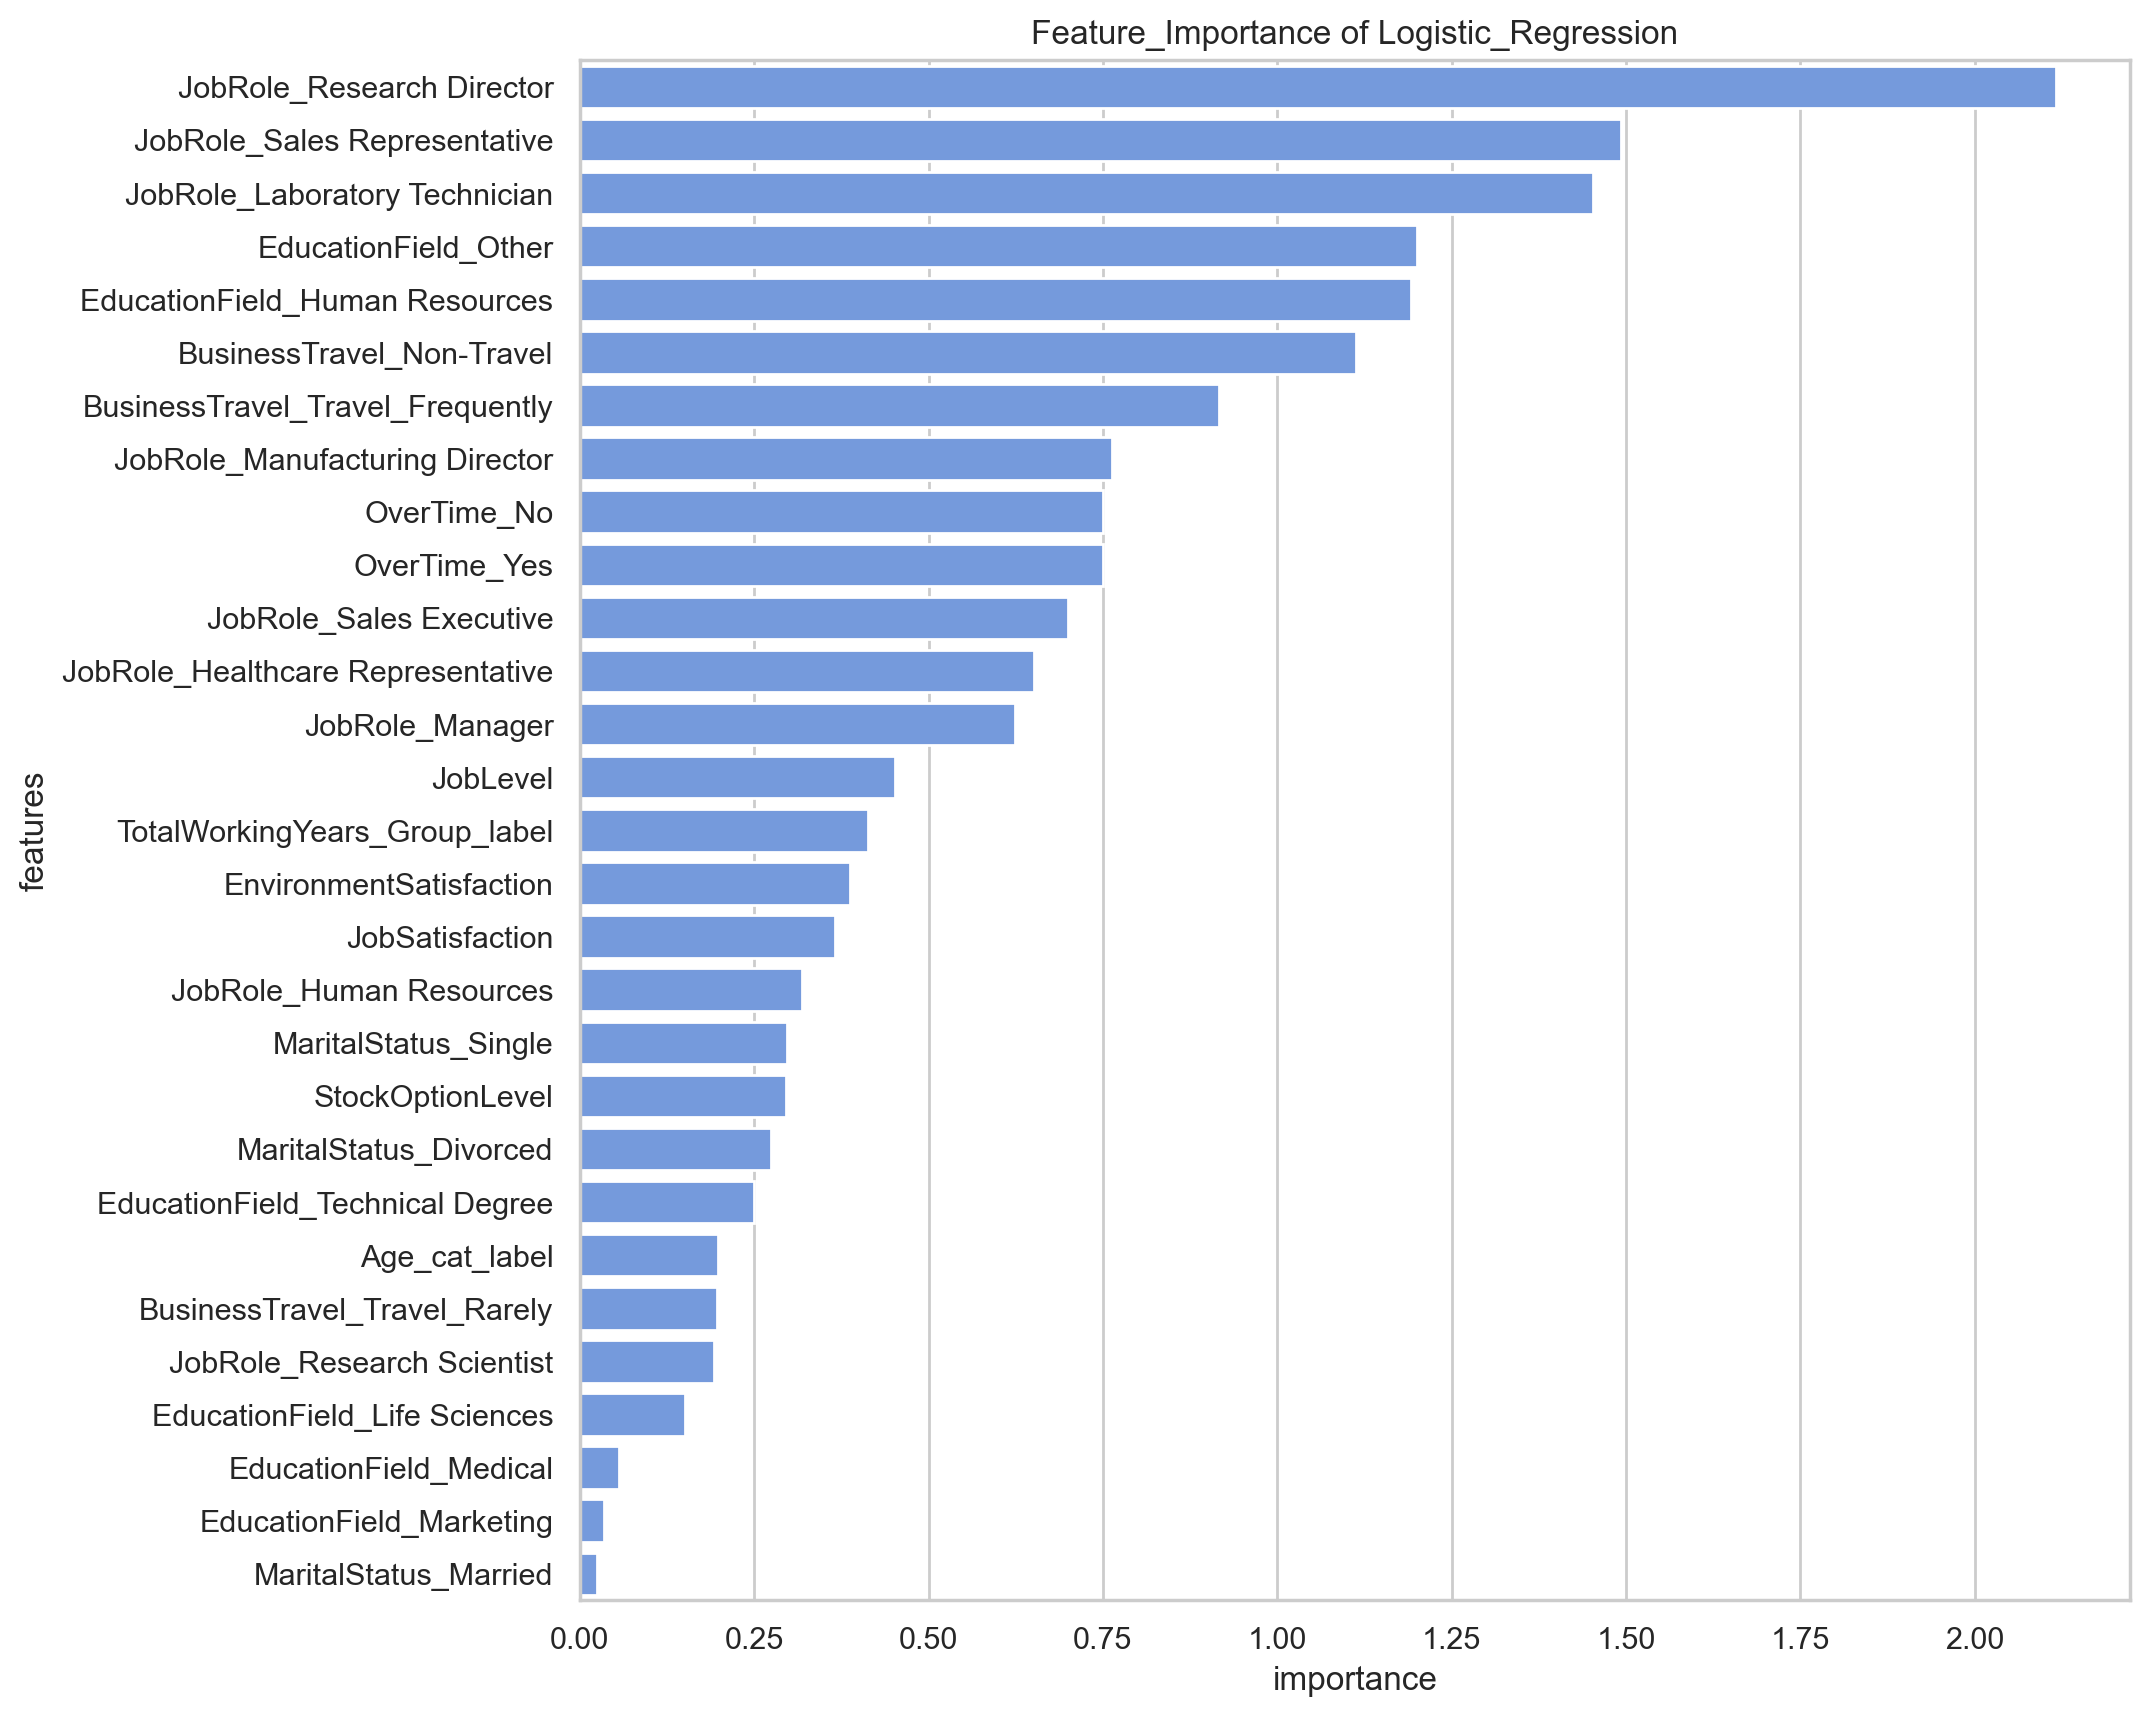

In [451]:
# feature_importance

# logistic regression 모델에서 계수(coefficient) 추출
lr_coef = model_lr.coef_[0]

# 계수의 절댓값으로 중요도 계산
lr_importance = np.abs(lr_coef)

# 중요도를 기준으로 내림차순으로 정렬하여 index 저장
lr_idx = np.argsort(lr_importance)[::-1]

# 중요도를 내림차순으로 정렬하여 저장
lr_sorted_importance = lr_importance[lr_idx]

# 변수명을 기준으로 x축 레이블 저장
feature_names = np.array(X_train_resampled.columns)
sorted_features = feature_names[lr_idx]

# 피처 중요도 데이터프레임 만들기
df_plt_importance = pd.DataFrame({'feature':sorted_features,
                                  'importance' : lr_sorted_importance})

# 바 그래프 그리기
plt.figure(figsize=(10,10))
sns.barplot(data=df_plt_importance, x='importance', y='feature', color='cornflowerblue')
plt.title('Feature_Importance of Logistic_Regression')
plt.xlabel('importance')
plt.ylabel('features')
plt.show()

## 로지스틱 + 그리드서치
* 최적 모델
* model_lr = LogisticRegression(C=0.1,max_iter=100)

In [452]:
# 하이퍼파라미터
param_grid_lr = {
    'C': [0.1, 0.125, 0.15, 0.5, 1, 5, 10],
    'max_iter':[100, 200, 300, 400, 500]
}

# 그리드서치 객체 생성
lr_gridcv = GridSearchCV(model_lr, param_grid=param_grid_lr, n_jobs=-1, cv=5, scoring='f1')

# 모델 학습
lr_gridcv.fit(X_train_resampled, y_train_resampled)

# 최적 하이퍼파라미터 출력
print("lr 최적 하이퍼파라미터:", lr_gridcv.best_params_)

# 최적 모델 저장
best_model = lr_gridcv.best_estimator_

# 모델 성능 평가
y_pred = best_model.predict(X_test)
metrics(y_test, y_pred)

/Users/jomac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


lr 최적 하이퍼파라미터: {'C': 10, 'max_iter': 100}
정확도 : 0.72, 정밀도 : 0.32, 재현율 : 0.66
f1-score : 0.43, auc : 0.70
              precision    recall  f1-score   support

           0       0.92      0.73      0.82       247
           1       0.32      0.66      0.43        47

    accuracy                           0.72       294
   macro avg       0.62      0.70      0.62       294
weighted avg       0.82      0.72      0.75       294



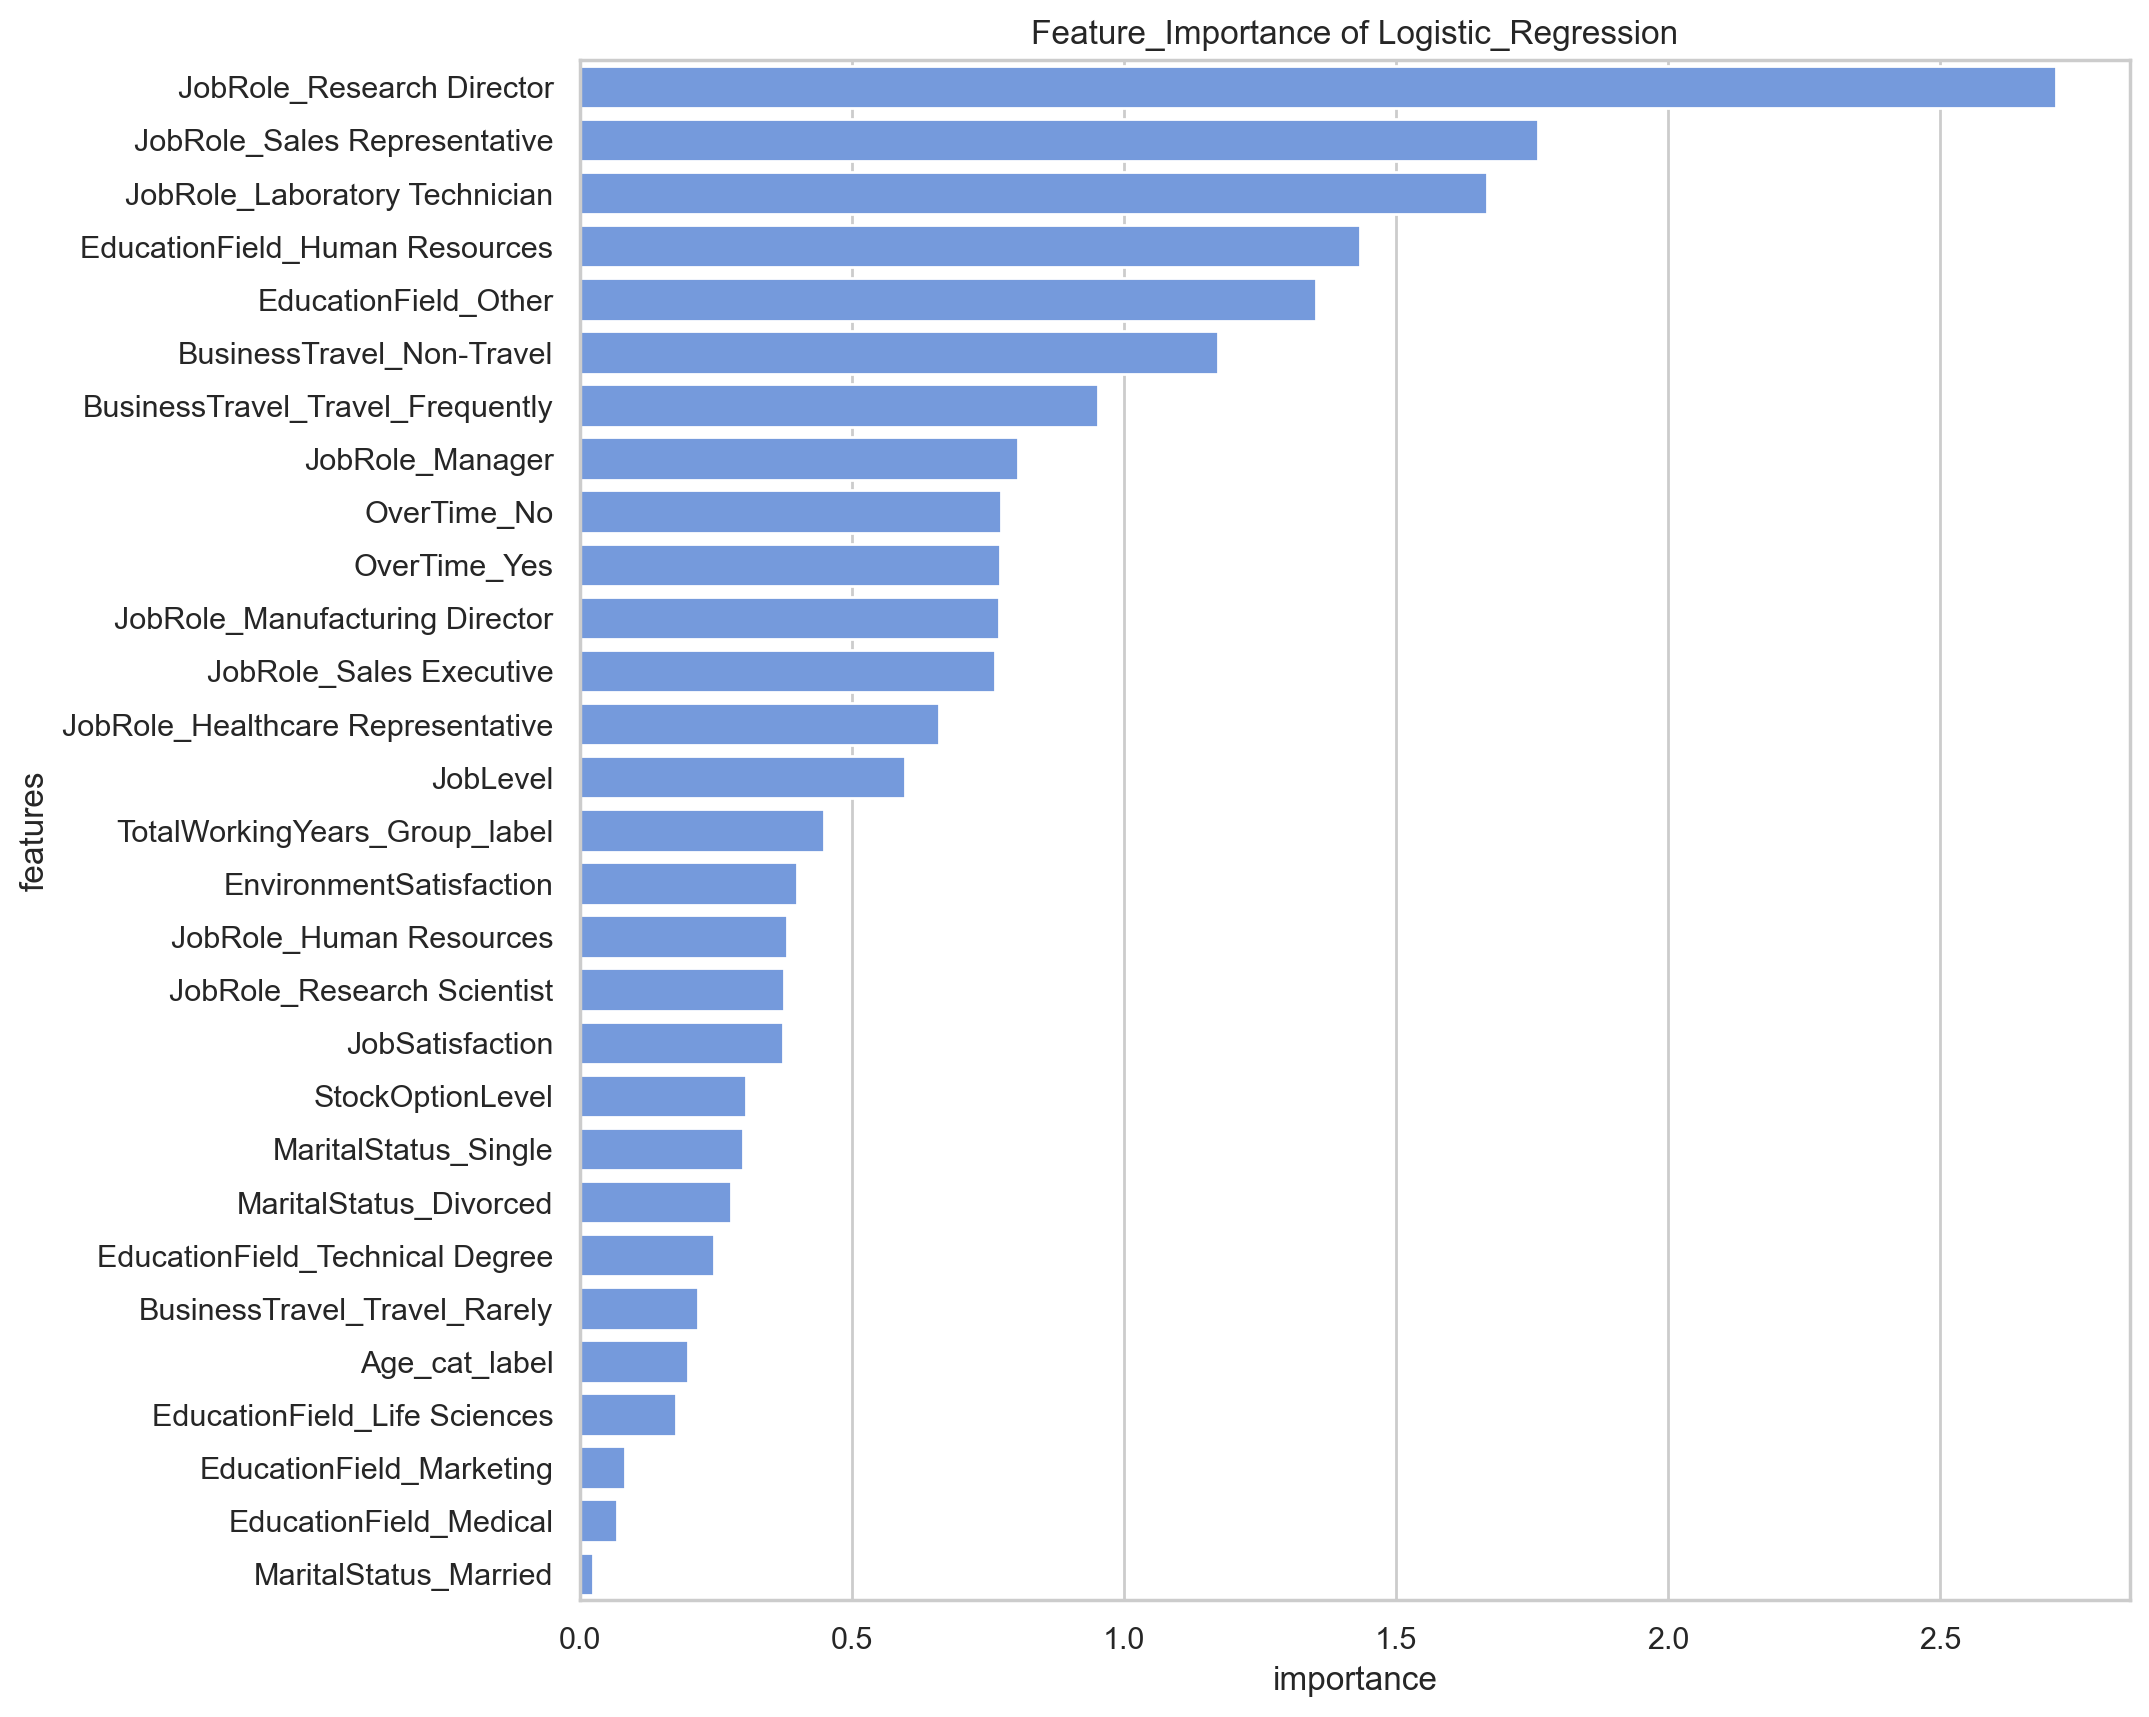

In [453]:
# feature_importance

# logistic regression 모델에서 계수(coefficient) 추출
lr_coef = best_model.coef_[0]

# 계수의 절댓값으로 중요도 계산
lr_importance = np.abs(lr_coef)

# 중요도를 기준으로 내림차순으로 정렬하여 index 저장
lr_idx = np.argsort(lr_importance)[::-1]

# 중요도를 내림차순으로 정렬하여 저장
lr_sorted_importance = lr_importance[lr_idx]

# 변수명을 기준으로 x축 레이블 저장
feature_names = np.array(X_train_resampled.columns)
sorted_features = feature_names[lr_idx]

# 피처 중요도 데이터프레임 만들기
df_plt_importance = pd.DataFrame({'feature':sorted_features,
                                  'importance' : lr_sorted_importance})

# 바 그래프 그리기
plt.figure(figsize=(10,10))
sns.barplot(data=df_plt_importance, x='importance', y='feature', color='cornflowerblue')
plt.title('Feature_Importance of Logistic_Regression')
plt.xlabel('importance')
plt.ylabel('features')
plt.show()

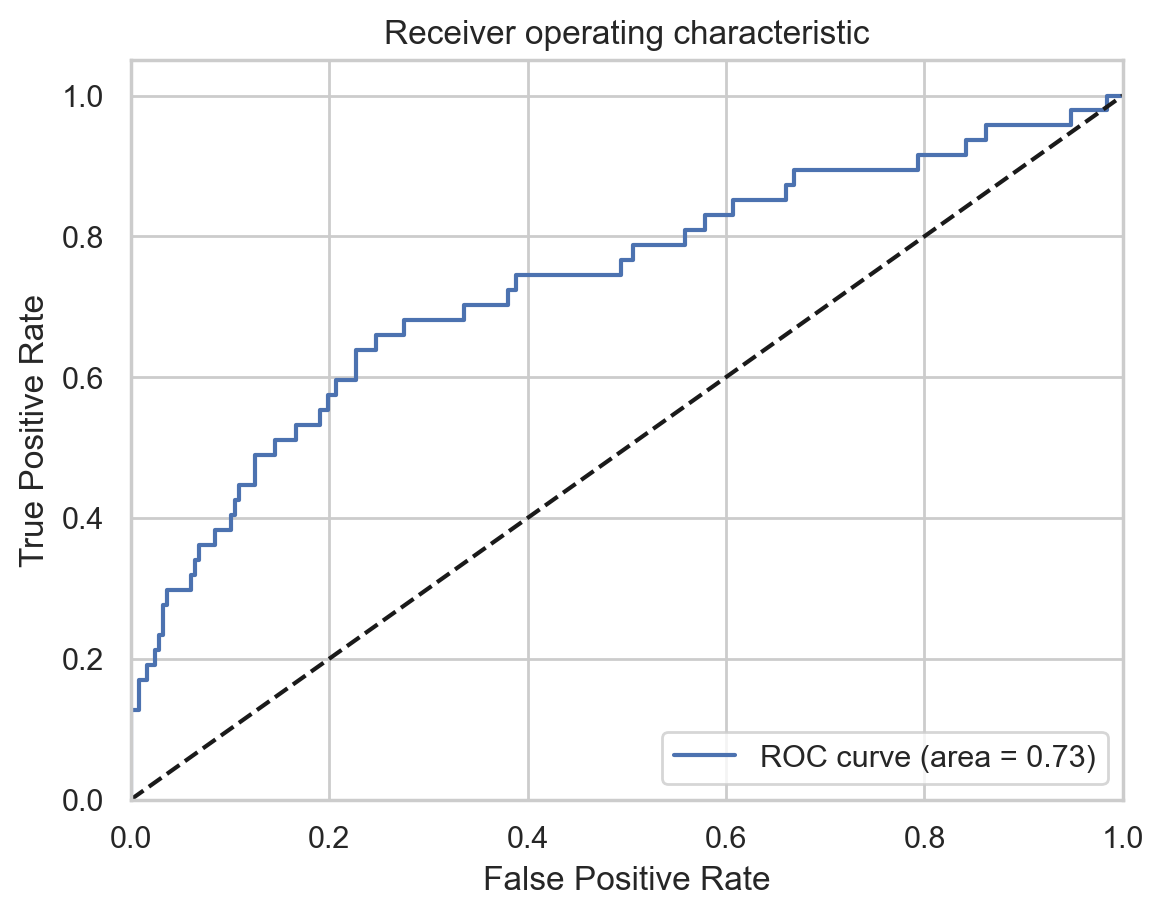

In [454]:
# ROC 커브
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## XGBoost
- 그리드서치를 통한 최적 모델
- model_xgb = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=8, colsample_bytree=0.9)

In [455]:
# # xgboost 모델
# model_xgb = xgb.XGBClassifier(random_state=42)

# # 하이퍼파라미터
# param_grid_xgb={
#     'n_estimators' : [500,600,700,800,900,1000],
#     'learning_rate' : [0.1,0.13, 0.15, 0.18],
#     'max_depth' : range(1, 11),
#     'colsample_bytree' : [0.7, 0.8, 0.9]}

# # 그리드서치 객체 생성
# xgb_gridcv = GridSearchCV(model_xgb, param_grid = param_grid_xgb, cv=3, n_jobs=-1, verbose=2, scoring="accuracy")

# # 모델 학습
# xgb_gridcv.fit(X_train_resampled, y_train_resampled)

# # 최적 하이퍼파라미터 출력
# print("xgb 최적 하이퍼파라미터:", xgb_gridcv.best_params_)

# # 최적 모델 저장
# best_model = xgb_gridcv.best_estimator_

# # 모델 성능 평가
# y_pred = best_model.predict(X_test)
# print(classification_report(y_test, y_pred))

In [456]:
# xgboost 모델
model_xgb = XGBClassifier(n_estimators=500,
                          max_depth=8,
                          colsample_bytree = 0.9,
                          reg_lambda = 2.5,
                          learning_rate= 0.01,
                          random_state = 42,
                          reg_alpha = 0.01)

# 모델 학습
model_xgb.fit(X_train_resampled, y_train_resampled)

# 모델 성능 평가
y_pred = model_xgb.predict(X_test)
metrics(y_test, y_pred)

정확도 : 0.87, 정밀도 : 0.66, 재현율 : 0.45
f1-score : 0.53, auc : 0.70
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       247
           1       0.66      0.45      0.53        47

    accuracy                           0.87       294
   macro avg       0.78      0.70      0.73       294
weighted avg       0.86      0.87      0.86       294



<AxesSubplot:>

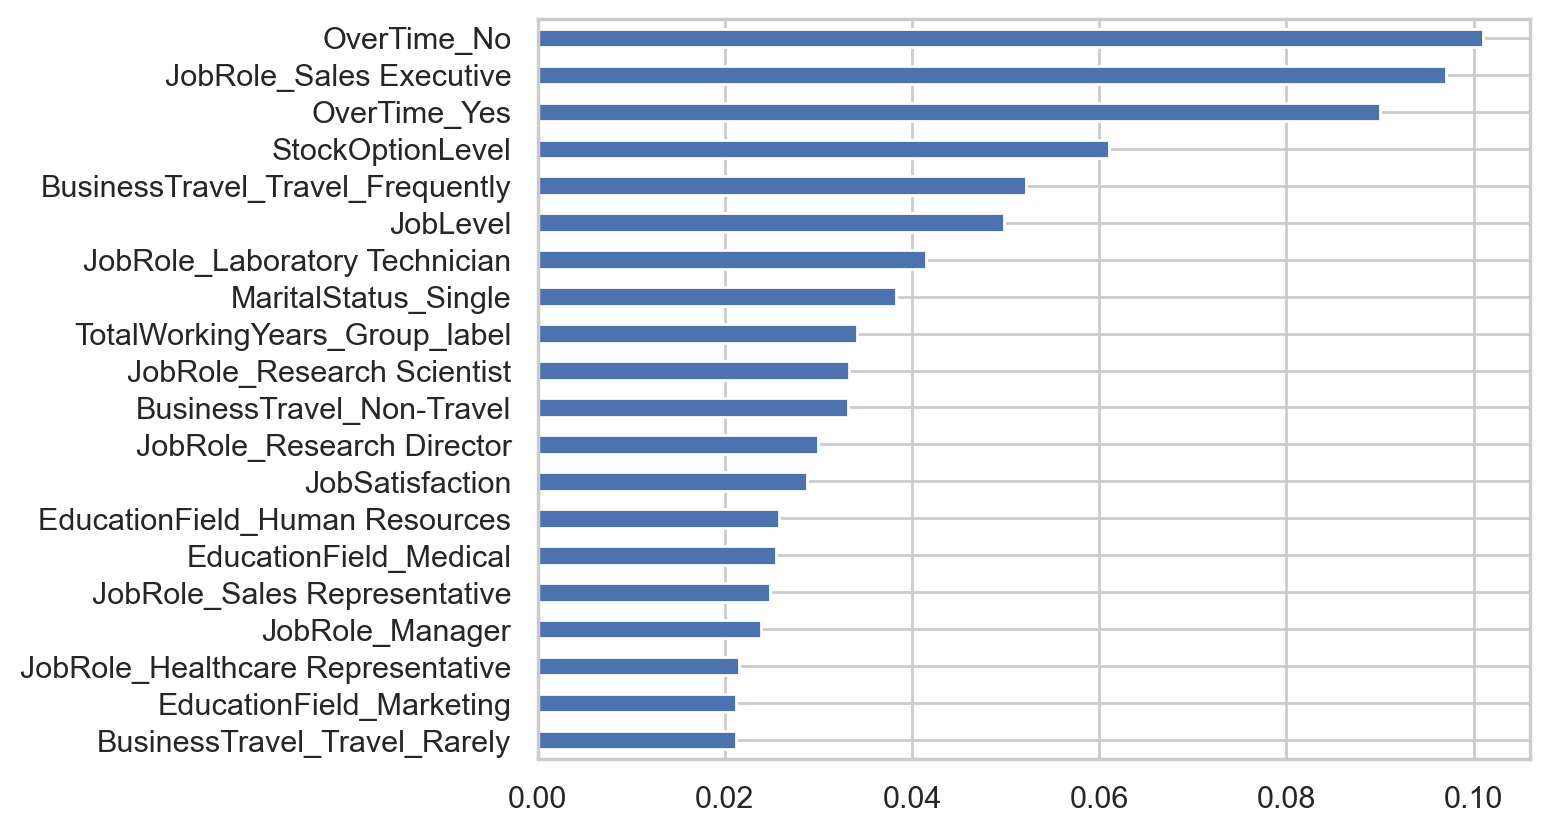

In [457]:
# model_xgb.feature_importances_
fi = pd.Series(model_xgb.feature_importances_)
fi.index = model_xgb.feature_names_in_
fi_sorted = fi.nlargest(20).sort_values(ascending=True)
fi_sorted.plot.barh()

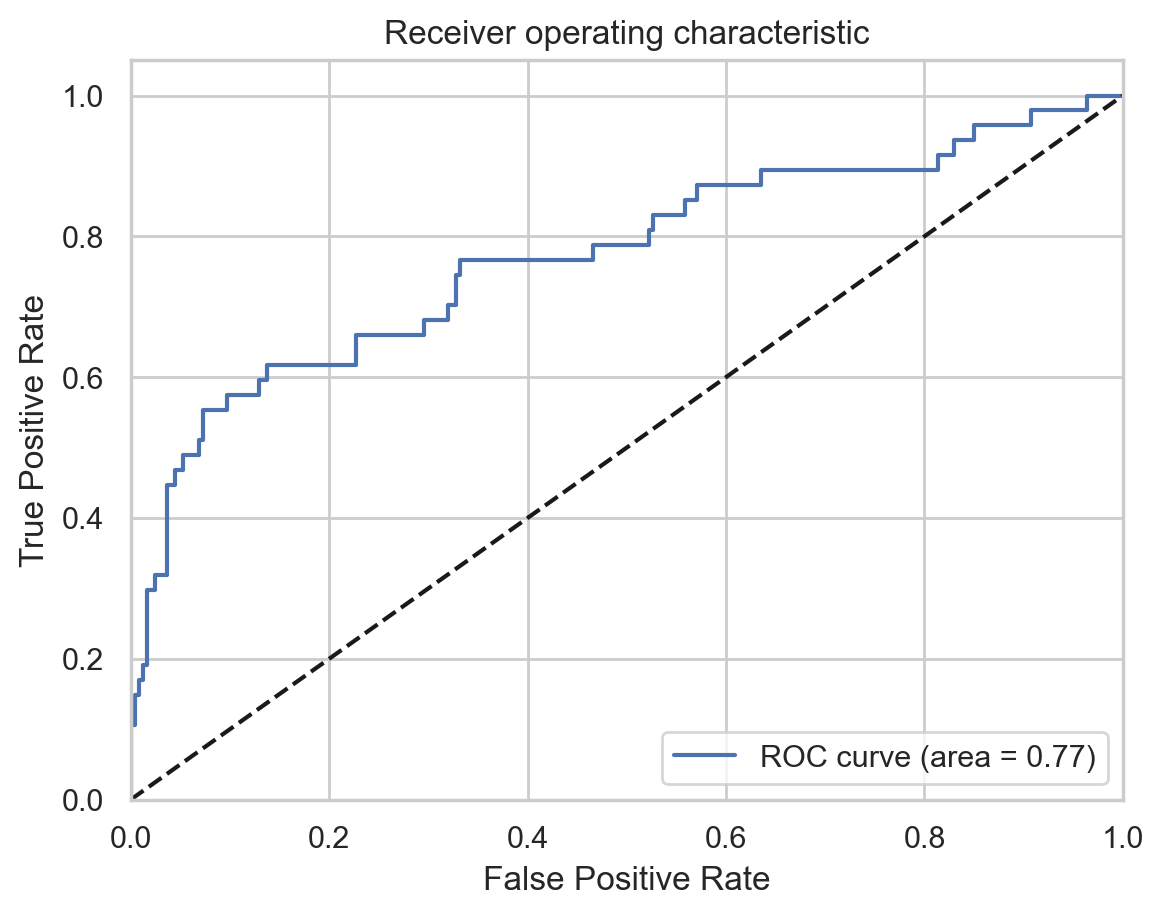

In [458]:
# ROC 커브
y_pred_prob = model_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## AdaBoost
- model_ada = AdaBoostClassifier(n_estimators=300, learning_rate=0.075)

In [461]:
# adaboost 모델
model_ada = AdaBoostClassifier(random_state=42)

# # 하이퍼파라미터
# param_grid_ada={
#     'n_estimators' : np.arange(100, 1000, 100),
#     'learning_rate' : np.arange(0.025, 1, 0.025),
# }

# # 그리드서치 객체 생성
# ada_gridcv = GridSearchCV(model_ada, param_grid = param_grid_ada, cv=5, n_jobs=-1, verbose=2, scoring="f1", error_score='raise')

# # 모델 학습
# ada_gridcv.fit(X_train_ada, y_train_ada)

# # 최적 하이퍼파라미터 출력
# print("ada 최적 하이퍼파라미터:", ada_gridcv.best_params_)

# # 최적 모델 저장
# best_model = ada_gridcv.best_estimator_

# # 모델 성능 평가
# y_pred = best_model.predict(X_test)
# print(classification_report(y_test, y_pred))

In [463]:
model_ada = AdaBoostClassifier(n_estimators=300, learning_rate=0.075)
model_ada.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(learning_rate=0.075, n_estimators=300)

<AxesSubplot:>

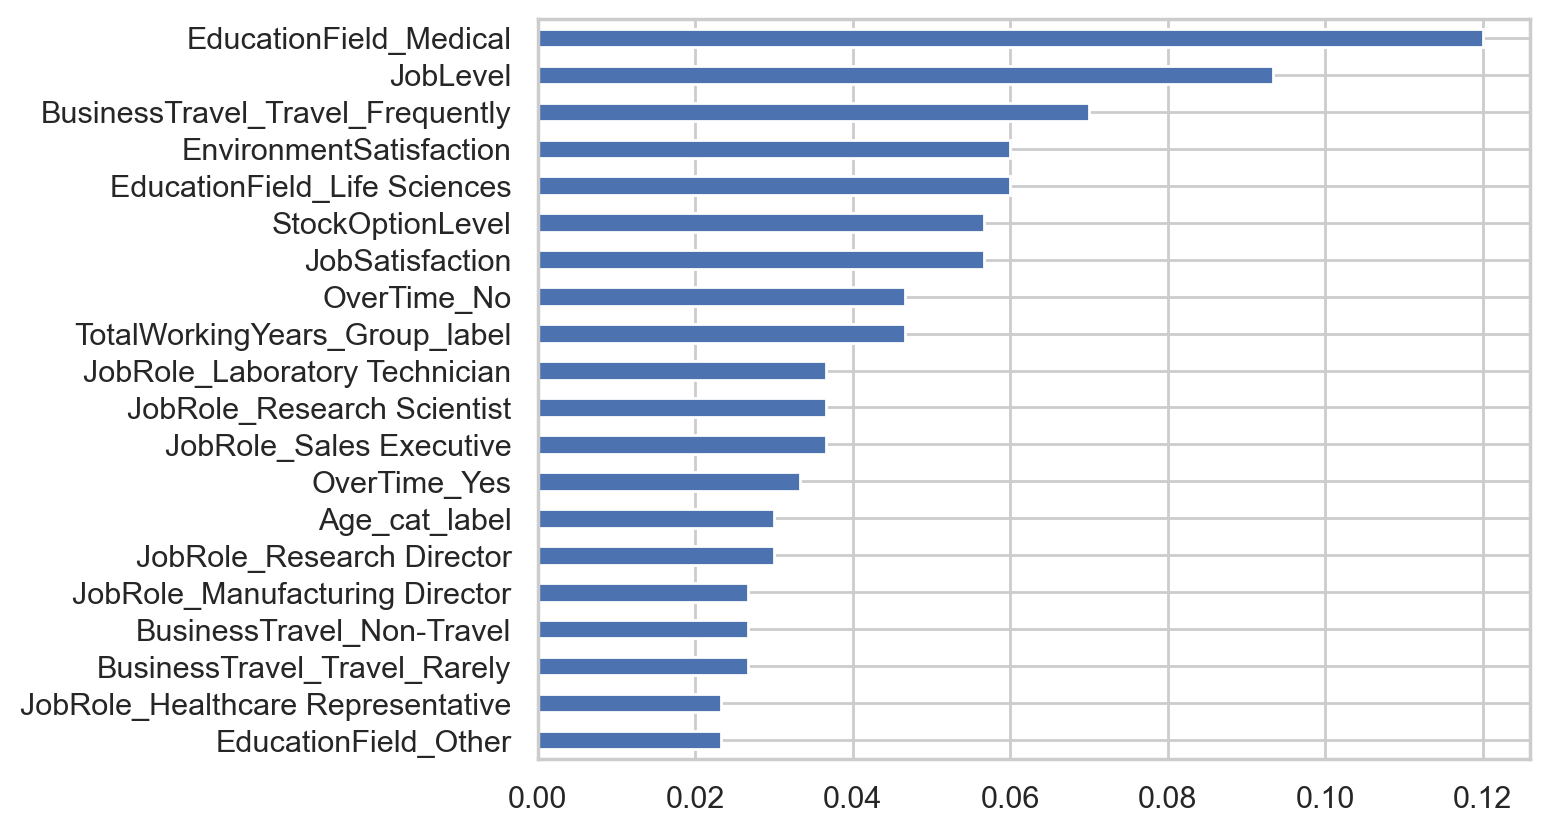

In [464]:
# model_ada.feature_importances_
fi = pd.Series(model_ada.feature_importances_)
fi.index = model_ada.feature_names_in_
fi_sorted = fi.nlargest(20).sort_values(ascending=True)
fi_sorted.plot.barh()

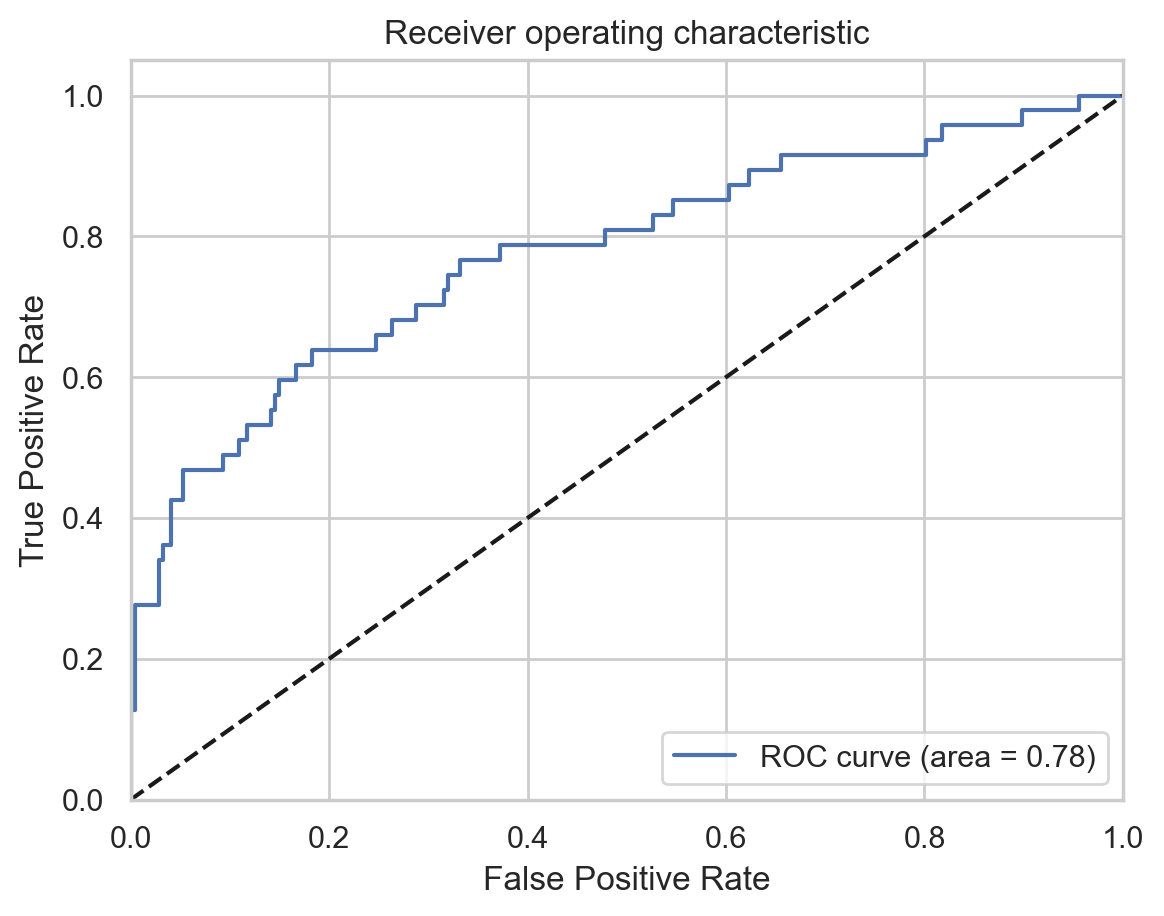

In [465]:
# ROC 커브
y_pred_prob = model_ada.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# 최종 모델 선정
- 가장 점수가 높은 XGBoost 모델 사용
- 피처 중요도를 통해 중요한 10개 피처 선택

In [482]:
# 데이터 불러오기
url = 'https://raw.githubusercontent.com/JounKK/AIS8_Final_HRA/main/dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv'
df_raw = pd.read_csv(url)

# EDA - 제거 피쳐 선정
drop_cols = ['Department', 'DistanceFromHome', 'Gender', 'NumCompaniesWorked', 'PercentSalaryHike', 
             'PerformanceRating', 'RelationshipSatisfaction', 'TrainingTimesLastYear' , 'YearsSinceLastPromotion',
             'DailyRate', 'HourlyRate', 'MonthlyRate', 'Over18', 'EmployeeCount', 'StandardHours','EmployeeNumber']

df_drop = df_raw.drop(columns=drop_cols)

# 변경에 파생변수 추가 및 라벨인코딩
label_encoder = LabelEncoder()

# 연차 파생변수 생성 : 5년마다 TotalWorkingYears 나누기
df_drop['TotalWorkingYears_Group'] = pd.cut(df_drop['TotalWorkingYears'], bins=range(0, df_drop['TotalWorkingYears'].max()+6, 5), right=False)
df_drop['TotalWorkingYears_Group_label'] = label_encoder.fit_transform(df_drop['TotalWorkingYears_Group'])
df_drop = df_drop.drop(columns=['TotalWorkingYears_Group','TotalWorkingYears'])

# 나이대 파생변수 생성
df_drop["Age_cat"] = (df_raw["Age"] // 10) * 10
df_drop['Age_cat_label'] = label_encoder.fit_transform(df_drop['Age_cat'])
df_drop = df_drop.drop(columns=['Age_cat', 'Age'])
df = df_drop.copy()

# 피처 추가 선정
df = df[["Attrition", "JobRole", "StockOptionLevel", "BusinessTravel", "OverTime", "MaritalStatus", 
       "EducationField", "JobLevel", "Age_cat_label", "EnvironmentSatisfaction", "TotalWorkingYears_Group_label",
       "JobSatisfaction"]]

# 목표 변수와 feature 나누기
# 정답값 나누기
X = df.drop('Attrition', axis=1)
y = df_drop['Attrition']

# y값 인코딩
y = y.apply(lambda x: 1 if x == 'Yes' else 0)
# 스케일링
# StandardScaler 객체 생성
scaler = StandardScaler()

# 스케일링 대상 feature 선택
num_cols = X.select_dtypes(exclude="O").columns.tolist()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 원핫인코딩
col_ohe = X.select_dtypes('O').columns

# OneHotEncoder 객체 생성 및 학습
ohe = OneHotEncoder(handle_unknown='ignore')

# 인코딩 범주찾기
X_ohe = ohe.fit_transform(X[col_ohe])
X_ohe.toarray()

# 인코딩된 데이터프레임 생성
df_ohe = pd.DataFrame(X_ohe.toarray(), columns=ohe.get_feature_names_out())

# 수치형과 병합
X_num = X.select_dtypes(exclude="object")
X_enc = pd.concat([X_num, df_ohe], axis=1)

# train, test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, stratify=y, random_state=42)

# ADASYN 오버샘플링
adasyn = ADASYN()
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# xgboost 모델
model_xgb = XGBClassifier(n_estimators=500,
                          max_depth=8,
                          colsample_bytree = 0.9,
                          reg_lambda = 2.5,
                          learning_rate= 0.01,
                          random_state = 42)

# 모델 학습
model_xgb.fit(X_train_resampled, y_train_resampled)

# 모델 성능 평가
y_pred = model_xgb.predict(X_test)
metrics(y_test, y_pred)

정확도 : 0.87, 정밀도 : 0.63, 재현율 : 0.47
f1-score : 0.54, auc : 0.71
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       247
           1       0.63      0.47      0.54        47

    accuracy                           0.87       294
   macro avg       0.77      0.71      0.73       294
weighted avg       0.86      0.87      0.86       294

